In [1]:
!pip install q numpy==1.17

In [0]:
import re

import os
from os import listdir
from os.path import isfile, join

import torch
from torch.utils.data import Dataset

import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import numpy as np

from PIL import Image

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1p1BWofDJOKXqCtO0JPT5VyuIPOsuxOuj' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1p1BWofDJOKXqCtO0JPT5VyuIPOsuxOuj" -O openlogo.tar && rm -rf /tmp/cookies.txt
!tar -xvf openlogo.tar

images_folder = "openlogo/JPEGImages"
annotations_folder = "openlogo/Annotations"
train_query_file = "openlogo/ImageSets/Main/train_test/train_all.txt"
test_query_file = "openlogo/ImageSets/Main/train_test/test_all.txt"

Streaming output truncated to the last 5000 lines.
openlogo/JPEGImages/hondaimg000205.jpg
openlogo/Annotations/apeimg000015.xml
openlogo/Annotations/siemens3.xml
openlogo/JPEGImages/logos32plus_003856.jpg
openlogo/JPEGImages/chanel41.jpg
openlogo/JPEGImages/Belgalogos_07582934.jpg
openlogo/JPEGImages/61839900.jpg
openlogo/Annotations/kraftimg000003.xml
openlogo/JPEGImages/logos32plus_000801.jpg
openlogo/Annotations/logos32plus_003692.xml
openlogo/JPEGImages/essoimg000006.jpg
openlogo/JPEGImages/logos32plus_001952.jpg
openlogo/Annotations/batman5.xml
openlogo/JPEGImages/Hisense_sportslogo_65.jpg
openlogo/Annotations/logos32plus_000073.xml
openlogo/JPEGImages/flickrlogo27_3778060828.jpg
openlogo/Annotations/boschimg000151.xml
openlogo/JPEGImages/aralimg000145.jpg
openlogo/Annotations/prada48.xml
openlogo/JPEGImages/fritolaysimg000043.jpg
openlogo/Annotations/logos32plus_000459.xml
openlogo/Annotations/logos32plus_004264.xml
openlogo/JPEGImages/boeingimg000044.jpg
openlogo/JPEGImages/logo

In [4]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 7729 (delta 4), reused 5 (delta 1), pack-reused 7701
Receiving objects: 100% (7729/7729), 10.71 MiB | 18.53 MiB/s, done.
Resolving deltas: 100% (5262/5262), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
image_pattern = re.compile(r'^(?P<key>\w+)\.jpg$')
annotation_pattern = re.compile(r'^(?P<key>\w+)\.xml$')

class LogoDetectionDataset(Dataset):
  
  def __init__(self, image_folder, annotation_folder, query_file, transform=None):
    self.image_folder = image_folder
    self.annotation_folder = annotation_folder
    self.transform = transform
    self.image_names = self.__get_file_names__(image_folder, image_pattern)
    self.annotation_names = self.__get_file_names__(annotation_folder, annotation_pattern)

    self.keys = sorted(list(set(self.image_names.keys()) & set(self.annotation_names.keys())))
    with open(query_file) as file:
      file_content = file.read()
      self.keys = list(filter(lambda key: key in file_content, self.keys))
  
  def __len__(self):
    return len(self.keys)

  def __getitem__(self, index): 
    key = self.keys[index]

    image_name = self.image_names[key]
    annotation_name = self.annotation_names[key]

    image_path = os.path.join(self.image_folder, image_name)
    annotation_path = os.path.join(self.annotation_folder, annotation_name)

    img = Image.open(image_path).convert('RGB')
    target = self.__get_target__(annotation_path, index)

    if self.transform:
      img, target = self.transform(img, target)

    return img, target

  def __get_target__(self, annotation_path, index):
    target = {}
    boxes = []
    root = ET.parse(annotation_path).getroot()
    for bndbox in root.findall('object/bndbox'):
      xmin = int(bndbox[0].text)
      ymin = int(bndbox[1].text)
      xmax = int(bndbox[2].text)
      ymax = int(bndbox[3].text)
      boxes.append((xmin, ymin, xmax, ymax))

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    num_objs = len(boxes)
    labels = torch.ones((num_objs), dtype=torch.int64)
    img_id = torch.tensor([index])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = img_id
    target['area'] = area
    target['iscrowd'] = iscrowd
    return target

  def __get_file_names__(self, folder, file_name_pattern):
    file_names = {}
    for f in listdir(folder):
      match = file_name_pattern.match(f)
      if not match:
        continue
      
      num = match.group('key')
      if num == '':
        continue
      
      file_names[num] = f

    return file_names

In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms

tfs = transforms.Compose([
                          transforms.ToTensor(),                       
                       ])

num_classes = 2
batch_size = 4

dataset = LogoDetectionDataset(images_folder, annotations_folder, train_query_file, transform=tfs)
test_dataset = LogoDetectionDataset(images_folder, annotations_folder, test_query_file, transform=tfs)
orig_test_dataset = LogoDetectionDataset(images_folder, annotations_folder, test_query_file)

validation_size = .0

data_size = len(dataset)
test_data_size = len(test_dataset)

split_val = int(np.floor(validation_size * data_size))

indices = list(range(data_size))
test_indices = list(range(test_data_size))
np.random.seed(42)
np.random.shuffle(indices)
np.random.shuffle(test_indices)
val_indices, train_indices = indices[:split_val], indices[split_val:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                         sampler=val_sampler, collate_fn=utils.collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          sampler=test_sampler, collate_fn=utils.collate_fn)

In [0]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [0]:
model = torch.load("drive/My Drive/save/save-hiper-2")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [9]:
last_saved_epoch = 3
num_epochs = 6

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_loader, device, last_saved_epoch + epoch, print_freq=1000)
  lr_scheduler.step()
  torch.save(model, "drive/My Drive/save/save-hiper-" + str(last_saved_epoch + epoch))
  #evaluate(model, val_loader, device=device)

torch.save(model, "drive/My Drive/save/save-hiper-complete")

Epoch: [3]  [   0/4634]  eta: 3:00:59  lr: 0.000500  loss: 0.0727 (0.0727)  loss_classifier: 0.0491 (0.0491)  loss_box_reg: 0.0109 (0.0109)  loss_objectness: 0.0090 (0.0090)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 2.3435  data: 0.3136  max mem: 4445
Epoch: [3]  [1000/4634]  eta: 0:55:02  lr: 0.000500  loss: 0.1094 (0.1053)  loss_classifier: 0.0594 (0.0580)  loss_box_reg: 0.0268 (0.0261)  loss_objectness: 0.0055 (0.0081)  loss_rpn_box_reg: 0.0116 (0.0131)  time: 0.9037  data: 0.1022  max mem: 8364
Epoch: [3]  [2000/4634]  eta: 0:39:42  lr: 0.000500  loss: 0.0825 (0.1067)  loss_classifier: 0.0512 (0.0587)  loss_box_reg: 0.0182 (0.0265)  loss_objectness: 0.0038 (0.0082)  loss_rpn_box_reg: 0.0062 (0.0134)  time: 0.8811  data: 0.0873  max mem: 8364
Epoch: [3]  [3000/4634]  eta: 0:24:37  lr: 0.000500  loss: 0.1072 (0.1087)  loss_classifier: 0.0679 (0.0595)  loss_box_reg: 0.0247 (0.0272)  loss_objectness: 0.0088 (0.0081)  loss_rpn_box_reg: 0.0074 (0.0138)  time: 0.8786  data: 0.0693  max me

In [10]:
model = torch.load("drive/My Drive/save/save-hiper-complete")
model.to(device)
evaluate(model, test_loader, device=device)

creating index...
index created!
Test:  [   0/8322]  eta: 0:36:41  model_time: 0.2030 (0.2030)  evaluator_time: 0.0428 (0.0428)  time: 0.2646  data: 0.0042  max mem: 8634
Test:  [ 100/8322]  eta: 0:14:01  model_time: 0.0725 (0.0752)  evaluator_time: 0.0031 (0.0042)  time: 0.1030  data: 0.0242  max mem: 8634
Test:  [ 200/8322]  eta: 0:13:28  model_time: 0.0755 (0.0749)  evaluator_time: 0.0033 (0.0039)  time: 0.0994  data: 0.0190  max mem: 8634
Test:  [ 300/8322]  eta: 0:13:08  model_time: 0.0743 (0.0748)  evaluator_time: 0.0030 (0.0038)  time: 0.0981  data: 0.0178  max mem: 8634
Test:  [ 400/8322]  eta: 0:12:54  model_time: 0.0735 (0.0749)  evaluator_time: 0.0032 (0.0037)  time: 0.0957  data: 0.0153  max mem: 8634
Test:  [ 500/8322]  eta: 0:12:57  model_time: 0.0732 (0.0751)  evaluator_time: 0.0033 (0.0038)  time: 0.0974  data: 0.0187  max mem: 8634
Test:  [ 600/8322]  eta: 0:12:47  model_time: 0.0726 (0.0749)  evaluator_time: 0.0030 (0.0038)  time: 0.0948  data: 0.0180  max mem: 8634
T

In [0]:
model = torch.load("drive/My Drive/save/save-hiper-complete")

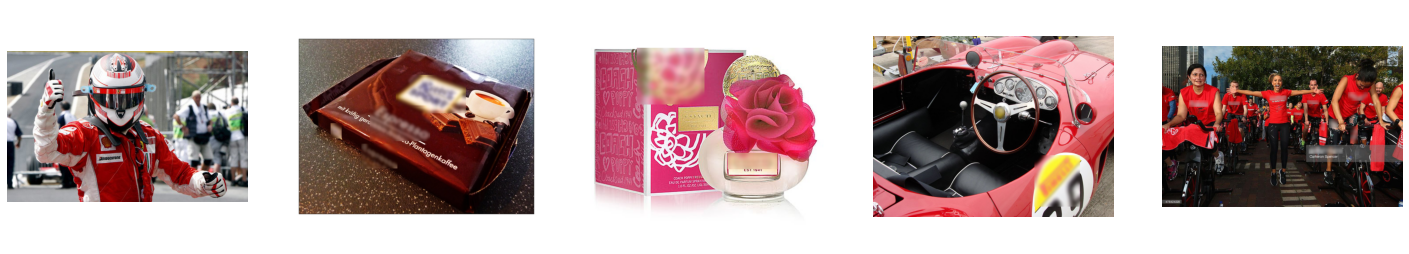

In [29]:
from PIL import ImageFilter

score_filter = 0.5

model.eval()
count = 5
plt.figure(figsize=(count * 5,5))
for i_step, (images, targets) in enumerate(test_loader):
  if i_step == count:
    break
    
  test_image = list(image.to(device) for image in images)
  prediction = model(test_image)[0]

  image_id = int(targets[0]['image_id'])
  image, target = orig_test_dataset[image_id]

  boxes = target['boxes']
  predict_boxes = prediction['boxes']
  predict_labels = prediction['labels']
  predict_scores = prediction['scores']

  plt.subplot(1, count, i_step + 1)

  #for box in boxes:
    #x = [box[0], box[2]]
    #y = [box[1], box[3]]
    #plt.plot(x, y, marker = 'o', label='Correct')
  for i, box in enumerate(predict_boxes):
    if predict_scores[i] < score_filter:
      continue
    ib = (int(box[0]), int(box[1]), int(box[2]), int(box[3]))
    ic = image.crop(ib)
    for i in range(20):
      ic = ic.filter(ImageFilter.GaussianBlur())
    image.paste(ic, ib)
    #x = [box[0], box[2]]
    #y = [box[1], box[3]]
    #predict_label = int(predict_labels[i])
    #view_label = 'Box - %d Label - %d' % (i, predict_label)
    #plt.plot(x, y, marker = 'o', label=view_label)

  plt.imshow(image)

  plt.grid(False)
  plt.axis('off')
  #plt.legend()  